In [1]:
import random
import cv2
import os
import torch
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from datasets import Dataset
from PIL import Image
from IPython.display import display
from patchify import patchify
from transformers import SamModel, SamConfig, SamProcessor

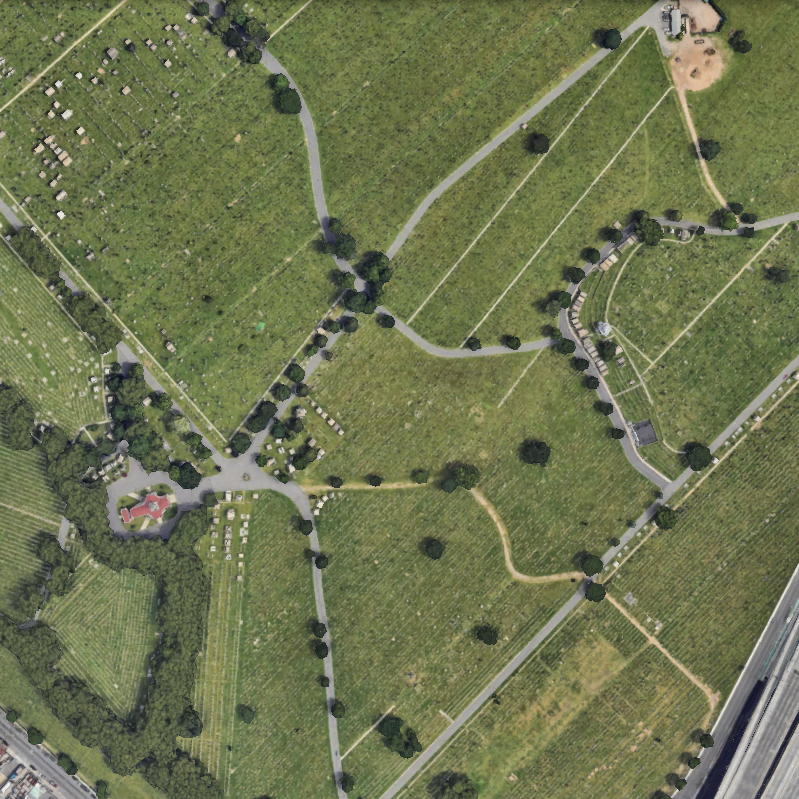

In [2]:
MODEL_FILE = "sam_model.pth"

IMAGE_FILE = "predict_this_1.png"

OUT_FOLDER = f"{IMAGE_FILE}_out"

image = Image.open(IMAGE_FILE)
rgbim = image.convert("RGB")

# crop to 1:1
w, h  = rgbim.size

length = min(w, h)

left   = (w - length) / 2
top    = (h - length) / 2
right  = (w + length) / 2
bottom = (h + length) / 2

square_image = rgbim.crop((left, top, right, bottom))
# Display
display(square_image)

In [4]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Model architecture w the loaded config
model = SamModel(config=model_config)
model.load_state_dict(torch.load(MODEL_FILE))

# Load the modified configuration from the JSON file
with open("sam-config.json", "r") as f:
    modified_config_dict = json.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", 
                                         **modified_config_dict)

In [5]:
new_image = np.array(rgbim)
print("Shape:",new_image.shape)

inputs = processor(new_image, return_tensors="pt")
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=inputs["pixel_values"], 
                  multimask_output=False)

Shape: (799, 891, 3)


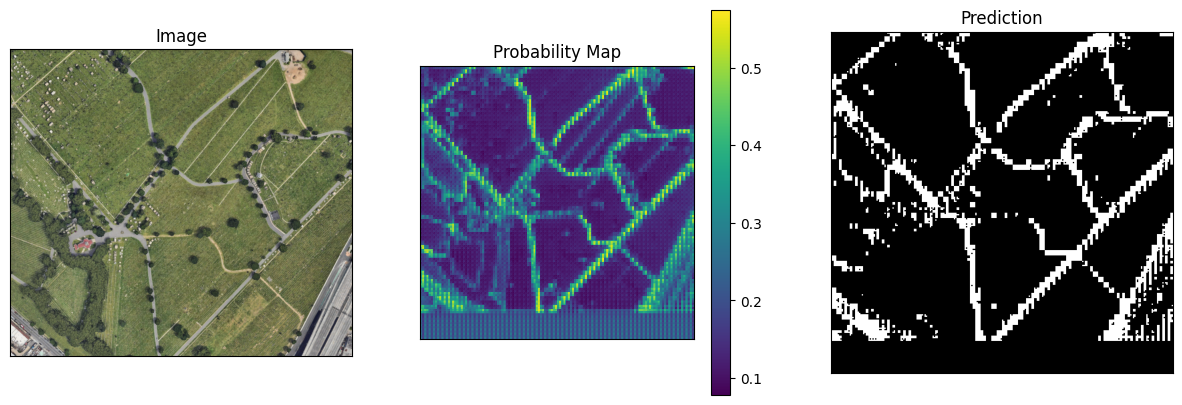

In [7]:
# apply sigmoid
pred_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
PROBABILITY_THRES = 0.30
pred_prob = pred_prob.cpu().numpy().squeeze()
pred_prediction = (pred_prob > PROBABILITY_THRES).astype(np.uint8)

# save
output_dir = OUT_FOLDER
os.makedirs(output_dir, exist_ok=True)

plt.imsave(os.path.join(output_dir, "probability_map.png"), pred_prob)

cv2.imwrite(os.path.join(output_dir, "prediction.png"), pred_prediction * 255) 

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(new_image, cmap='gray')
axes[0].set_title("Image")

im = axes[1].imshow(pred_prob) 
axes[1].set_title("Probability Map")
cbar = fig.colorbar(im, ax=axes[1])

axes[2].imshow(pred_prediction, cmap='gray')
axes[2].set_title("Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [11]:
print(new_image)

[[[128 127  99]
  [154 146 122]
  [164 154 132]
  ...
  [106 100  69]
  [110 103  71]
  [110 102  71]]

 [[170 161 136]
  [158 152 125]
  [138 135 105]
  ...
  [ 93  90  60]
  [ 98  97  68]
  [101 100  72]]

 [[137 136 103]
  [107 111  75]
  [ 90  97  59]
  ...
  [104 104  79]
  [103 103  78]
  [ 96  95  71]]

 ...

 [[214 215 214]
  [214 215 214]
  [214 215 214]
  ...
  [213 210 205]
  [209 205 200]
  [199 194 190]]

 [[214 215 214]
  [214 215 214]
  [215 215 215]
  ...
  [214 212 212]
  [214 211 207]
  [212 209 204]]

 [[214 215 214]
  [214 214 214]
  [216 214 216]
  ...
  [214 215 222]
  [214 214 219]
  [207 206 205]]]
